# Retrieve sensor log from Raspberry Pi and graph it
This version works with monthly created csv files *_yyyy-mm.csv

In [1]:
# Read raspberry pi access data from secrets file
import sys
import os

# Add the directory containing Secrets.py to the Python path
sys.path.append(os.path.abspath("/Users/alvazi2/Documents/JupyterLab/AlvaziLib"))

from Secrets import Secrets #from AlvaziLib (to do: rename to AlvaziSecrets to make this clearer)

PATH = "../Secrets/"
SECRETS_FILENAME = "AlvaziSecrets.json"
secrets = Secrets(PATH, SECRETS_FILENAME)
logFilePath = "sensor_logs/"
graphsPath = "graphs/"

In [2]:
# print python status
from platform import python_version
print(python_version())

3.12.7


In [3]:
import glob

# Set log file name pattern: sensor_log_yyyy-mm.csv
LogFilePattern = 'sensor_log_{}-{}.csv'

# get list of local files that match this pattern
csv_files = glob.glob(LogFilePattern.format('*', '*'), root_dir=logFilePath)
csv_files.sort()
print(csv_files)

# Note: renamed the original big file to sensor_log_2023-00 to fit into the pattern

['sensor_log_2023-00.csv', 'sensor_log_2023-01.csv', 'sensor_log_2023-02.csv', 'sensor_log_2023-03.csv', 'sensor_log_2023-04.csv', 'sensor_log_2023-05.csv', 'sensor_log_2023-06.csv', 'sensor_log_2023-07.csv', 'sensor_log_2023-08.csv', 'sensor_log_2023-09.csv', 'sensor_log_2023-10.csv', 'sensor_log_2023-11.csv', 'sensor_log_2023-12.csv', 'sensor_log_2024-01.csv', 'sensor_log_2024-02.csv', 'sensor_log_2024-03.csv', 'sensor_log_2024-04.csv', 'sensor_log_2024-05.csv', 'sensor_log_2024-06.csv', 'sensor_log_2024-07.csv', 'sensor_log_2024-08.csv', 'sensor_log_2024-09.csv', 'sensor_log_2024-10.csv', 'sensor_log_2024-11.csv', 'sensor_log_2024-12.csv', 'sensor_log_2025-01.csv', 'sensor_log_2025-02.csv', 'sensor_log_2025-03.csv', 'sensor_log_2025-04.csv', 'sensor_log_2025-05.csv']


In [4]:
import datetime
import pytz

# set my time zone
myTimeZone = 'US/Pacific'

#get current year and month
now = datetime.datetime.now(pytz.timezone(myTimeZone))
year = now.strftime("%Y")
month = now.strftime("%m")

In [5]:
from paramiko import SSHClient
from scp import SCPClient

# get login info for my Raspberry Pi
RaspberryPi = secrets.secret("Raspberry Pi 2013")["IP"]
MyUser = secrets.secret("Raspberry Pi 2013")["USER"]
MyPassword = secrets.secret("Raspberry Pi 2013")["PASSWORD"]
RemotePath = 'Adafruit_Python_BMP/'

# add sensor log file for current month (for the case when not yet transferred)
LogFile = LogFilePattern.format(year, month)
if LogFile not in csv_files:
    csv_files.append(LogFile)

# get ssh client to connect to my Raspberry Pi
ssh = SSHClient() #secure shell SSH connection
ssh.load_system_host_keys()
ssh.connect(RaspberryPi, username=MyUser, password=MyPassword, look_for_keys=False)
scp = SCPClient(ssh.get_transport())

# copy sensor log files from my Raspberry Pi
# only get the two latest monthly files (assuming that last download is not more than 2 months ago)
csv_files.sort(reverse=True)
for csv_file in csv_files[:2]:
    if csv_file != 'sensor_log_2023-00.csv':
        print(csv_file)
        scp.get(RemotePath+csv_file, logFilePath+csv_file)
scp.close()

sensor_log_2025-05.csv
sensor_log_2025-04.csv


In [6]:
import pandas as pd

# read sensor log files (CSV format) into pandas dataframe objects
# concatenate into a single dataframe object
frames = []
csv_files.sort(reverse=False)
for csv_file in csv_files:
    print(csv_file)
    df = pd.read_csv(logFilePath+csv_file, index_col=0, parse_dates=True, usecols=['TimeStamp', 'Temp', 'Pressure'])
    frames.append(df)
sensorLog = pd.concat(frames)

# round timestamp to full minutes
sensorLog.index = pd.to_datetime(sensorLog.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M')))

# localize timestamp index to my timezone
sensorLog.index = sensorLog.index.tz_localize(myTimeZone, ambiguous='infer')

# print most recent 10 sensor log entries
sensorLog.tail(10)

sensor_log_2023-00.csv
sensor_log_2023-01.csv
sensor_log_2023-02.csv
sensor_log_2023-03.csv
sensor_log_2023-04.csv
sensor_log_2023-05.csv
sensor_log_2023-06.csv
sensor_log_2023-07.csv
sensor_log_2023-08.csv
sensor_log_2023-09.csv
sensor_log_2023-10.csv
sensor_log_2023-11.csv
sensor_log_2023-12.csv
sensor_log_2024-01.csv
sensor_log_2024-02.csv
sensor_log_2024-03.csv
sensor_log_2024-04.csv
sensor_log_2024-05.csv
sensor_log_2024-06.csv
sensor_log_2024-07.csv
sensor_log_2024-08.csv
sensor_log_2024-09.csv
sensor_log_2024-10.csv
sensor_log_2024-11.csv
sensor_log_2024-12.csv
sensor_log_2025-01.csv
sensor_log_2025-02.csv
sensor_log_2025-03.csv
sensor_log_2025-04.csv
sensor_log_2025-05.csv


,Temp,Pressure
TimeStamp,,
2025-05-02 10:00:00-07:00,16.0,101070.0
2025-05-02 10:15:00-07:00,16.2,101082.0
2025-05-02 10:30:00-07:00,16.4,101099.0
2025-05-02 10:45:00-07:00,16.5,101104.0
2025-05-02 11:00:00-07:00,16.7,101107.0
2025-05-02 11:15:00-07:00,16.9,101119.0
2025-05-02 11:30:00-07:00,16.9,101107.0
2025-05-02 11:45:00-07:00,17.4,101100.0
2025-05-02 12:00:00-07:00,17.7,101086.0


In [7]:
# timestamp string for plots
UpdatedTimestamp = 'Updated {}'.format(now.strftime('%Y-%m-%d %H:%M'))

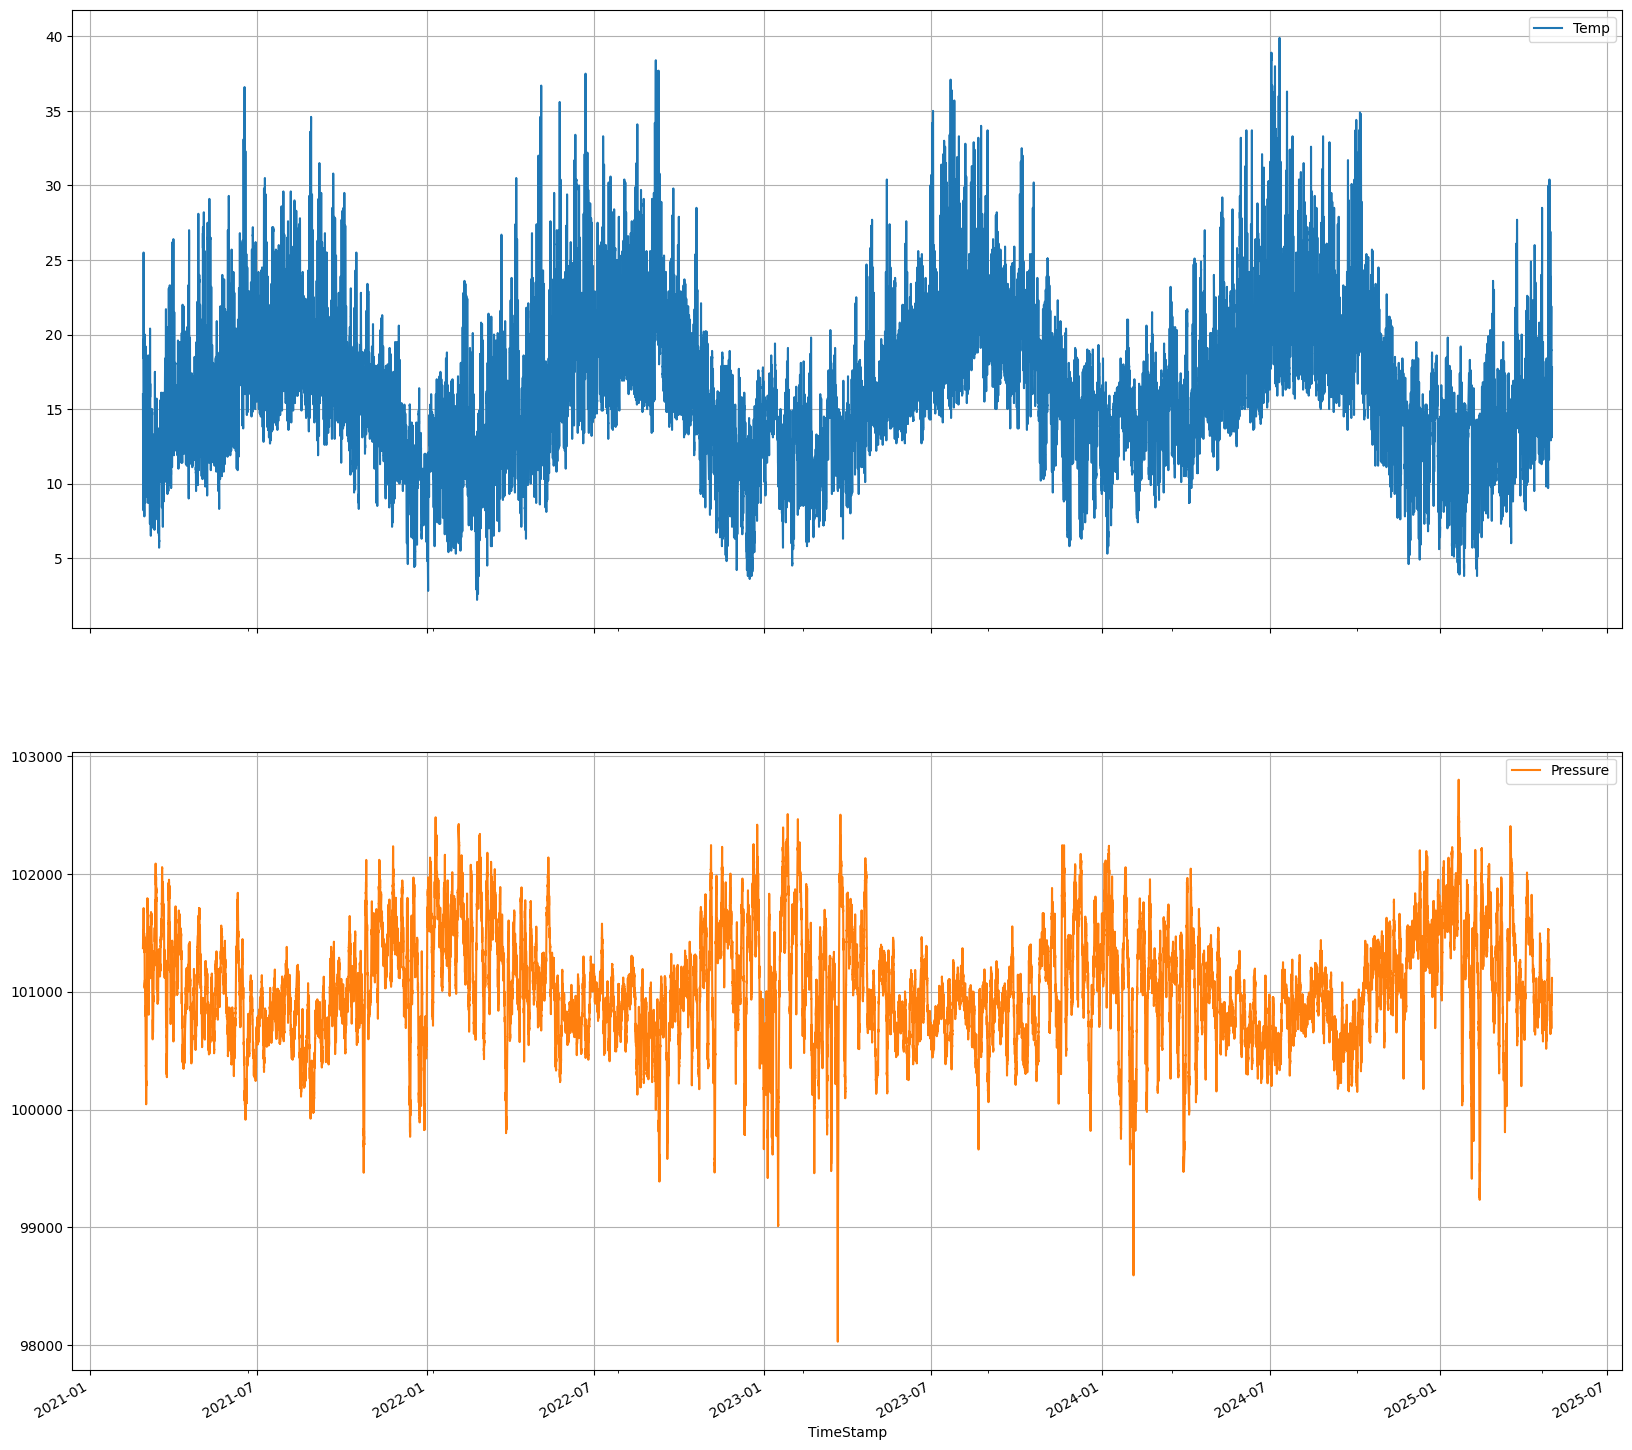

In [8]:
import matplotlib.pyplot as plt

# plot all data columns
axs = sensorLog.plot(figsize=(20,20), grid=True, subplots=True)

2025-05-02
            Temp       Pressure
count  50.000000      50.000000
mean   14.290000  100985.040000
std     1.452268      68.491012
min    13.100000  100888.000000
25%    13.300000  100933.500000
50%    13.450000  100966.500000
75%    15.275000  101039.500000
max    17.800000  101119.000000


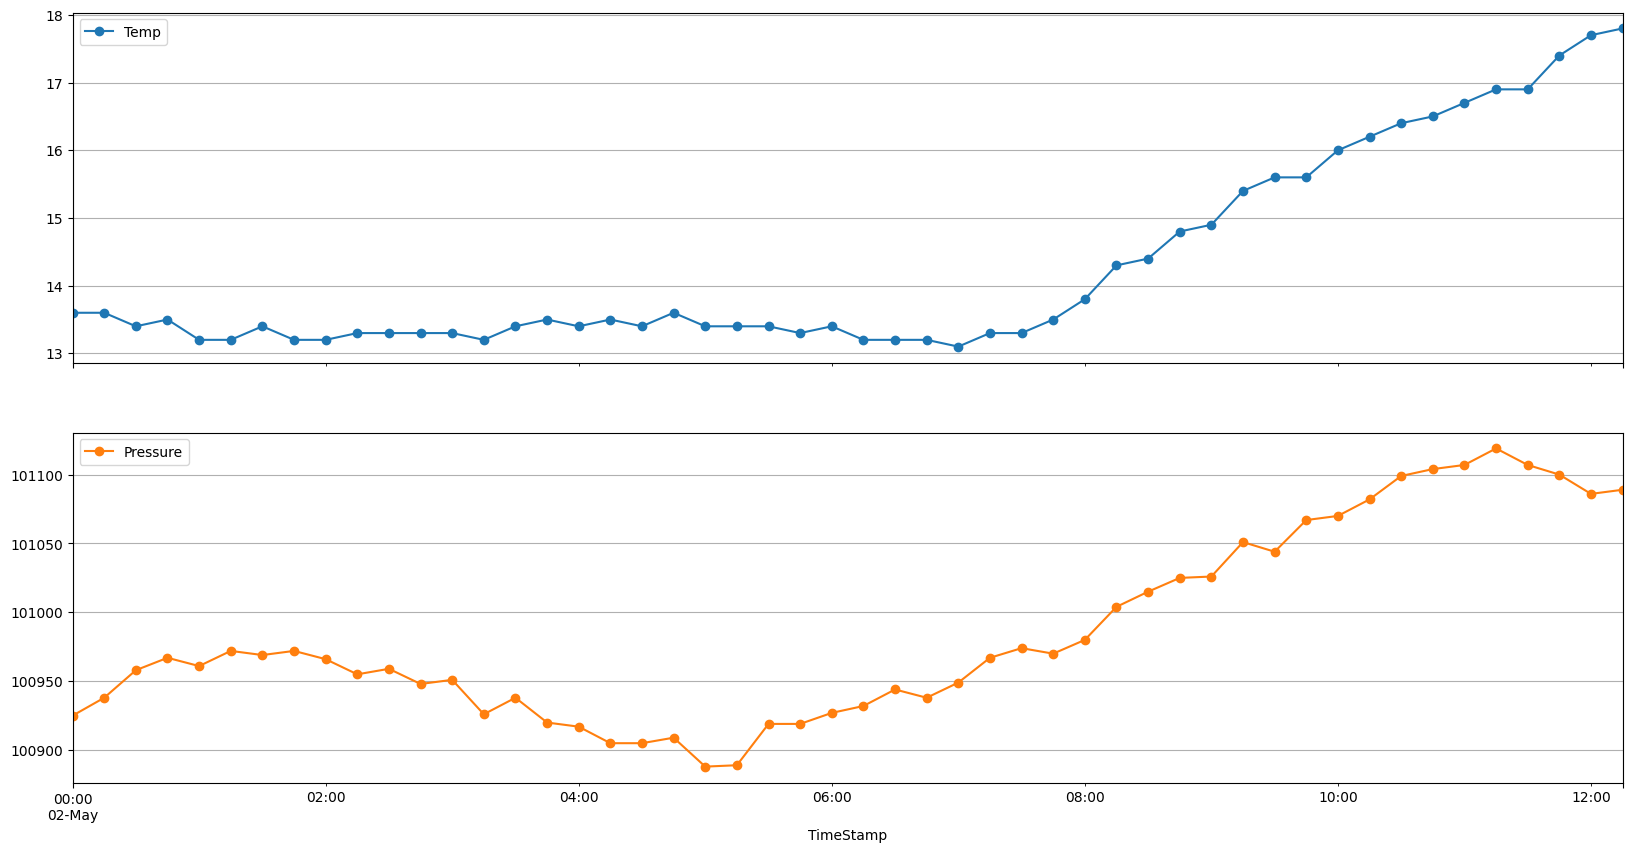

In [9]:
today = datetime.date.today().isoformat()
print(today)

# plot today's temperature and pressure
axs = sensorLog.loc[today:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='o', subplots=True)

print(sensorLog.loc[today:today].describe())

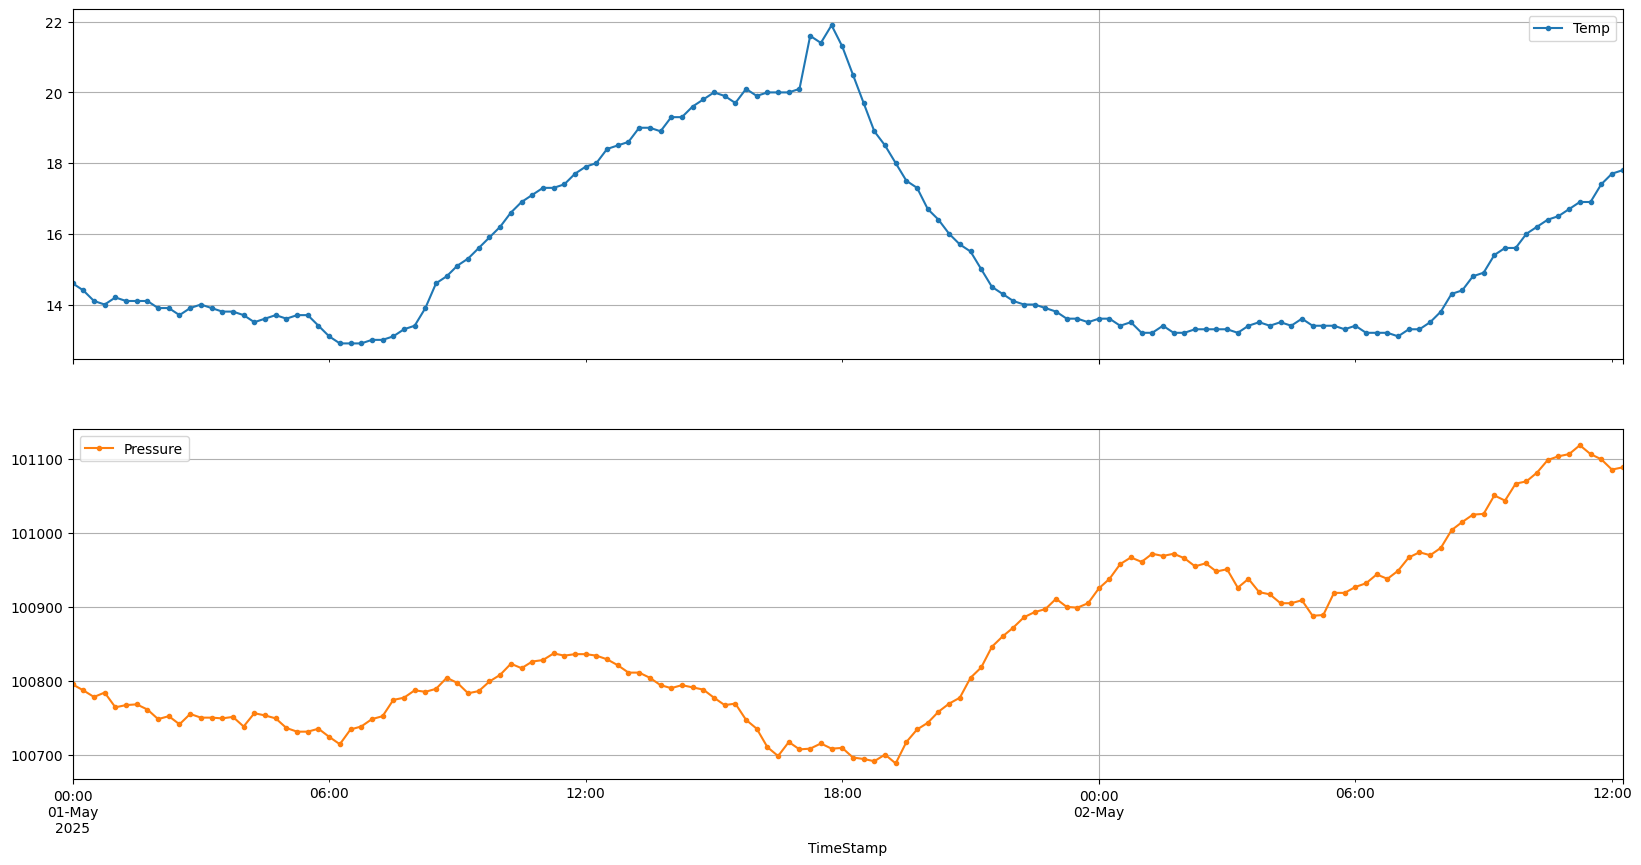

In [10]:
# plot yesterday's and today's temperature and pressure
yesterday = (datetime.date.today() - datetime.timedelta(days = 1)).isoformat()
axs = sensorLog.loc[yesterday:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='.', subplots=True)

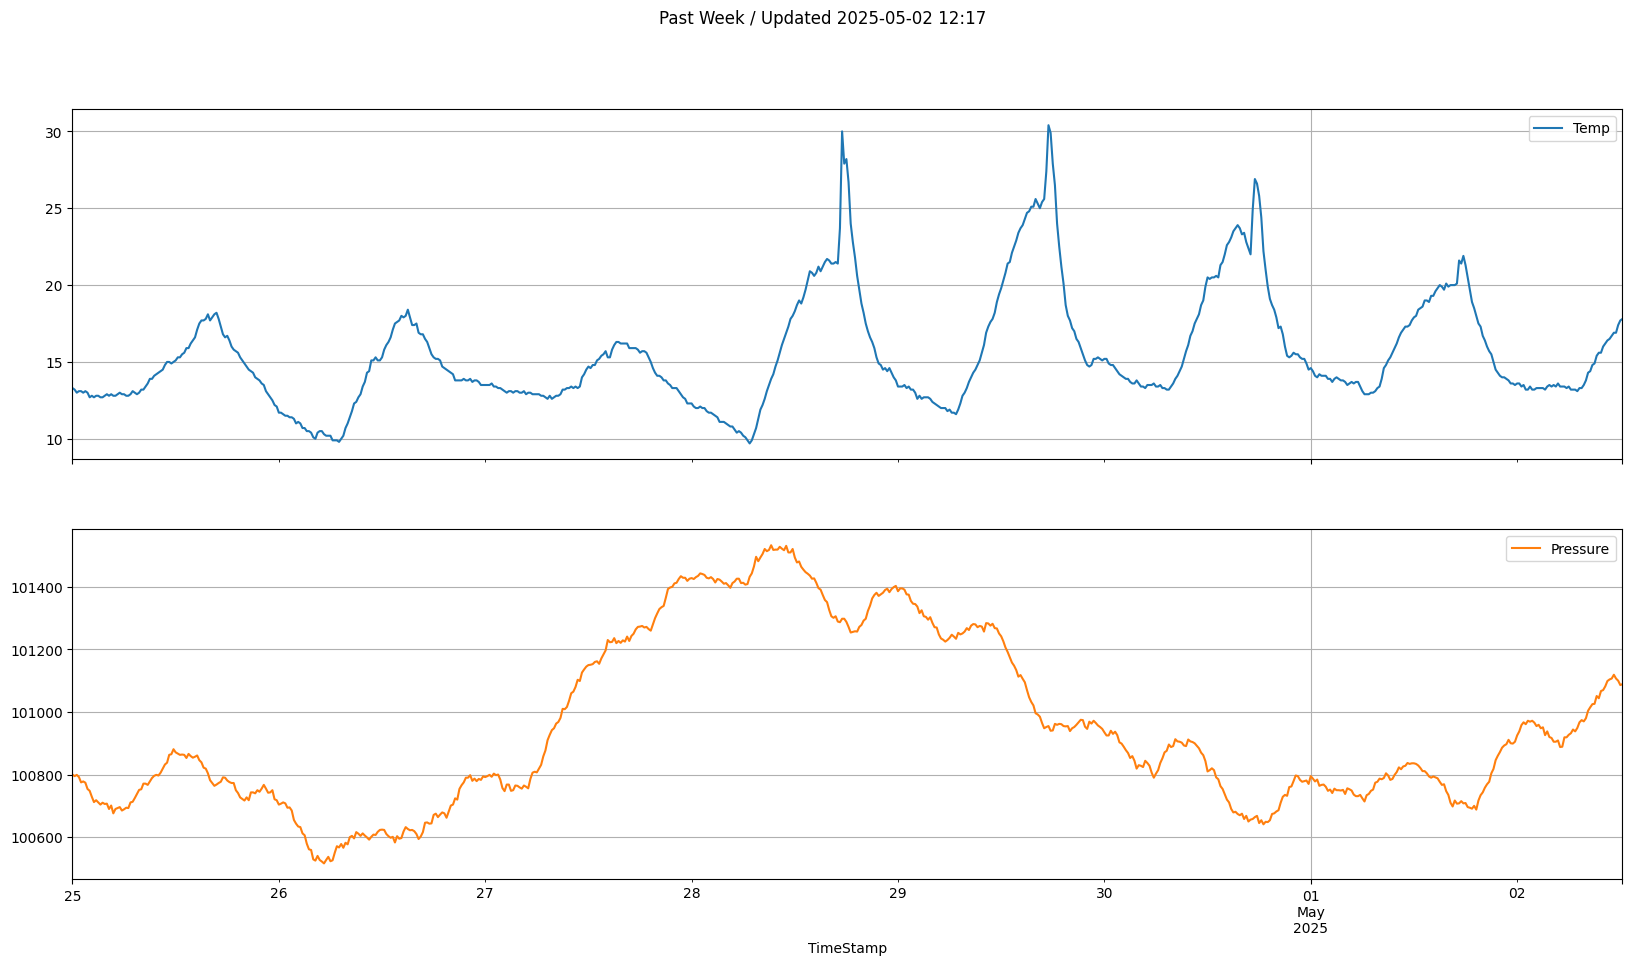

In [11]:
# plot past week's temperature and pressure
weekago = (datetime.date.today() - datetime.timedelta(weeks = 1)).isoformat() 
axs = sensorLog.loc[weekago:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title=f'Past Week / {UpdatedTimestamp}')

# save plot as file
plt.savefig(graphsPath+'pastWeekPlot')

In [12]:
sensorLog.axes

[DatetimeIndex(['2021-02-27 17:03:00-08:00', '2021-02-27 17:15:00-08:00',
                '2021-02-27 17:30:00-08:00', '2021-02-27 17:45:00-08:00',
                '2021-02-27 18:00:00-08:00', '2021-02-27 18:15:00-08:00',
                '2021-02-27 18:30:00-08:00', '2021-02-27 18:45:00-08:00',
                '2021-02-27 19:00:00-08:00', '2021-02-27 19:15:00-08:00',
                ...
                '2025-05-02 10:00:00-07:00', '2025-05-02 10:15:00-07:00',
                '2025-05-02 10:30:00-07:00', '2025-05-02 10:45:00-07:00',
                '2025-05-02 11:00:00-07:00', '2025-05-02 11:15:00-07:00',
                '2025-05-02 11:30:00-07:00', '2025-05-02 11:45:00-07:00',
                '2025-05-02 12:00:00-07:00', '2025-05-02 12:15:00-07:00'],
               dtype='datetime64[ns, US/Pacific]', name='TimeStamp', length=146355, freq=None),
 Index(['Temp', 'Pressure'], dtype='object')]

In [13]:
sensorLog.loc[weekago:today].agg(['min', 'max', 'mean'])

,Temp,Pressure
min,9.700000,100516.000000
max,30.400000,101533.000000
mean,15.480609,100948.977839


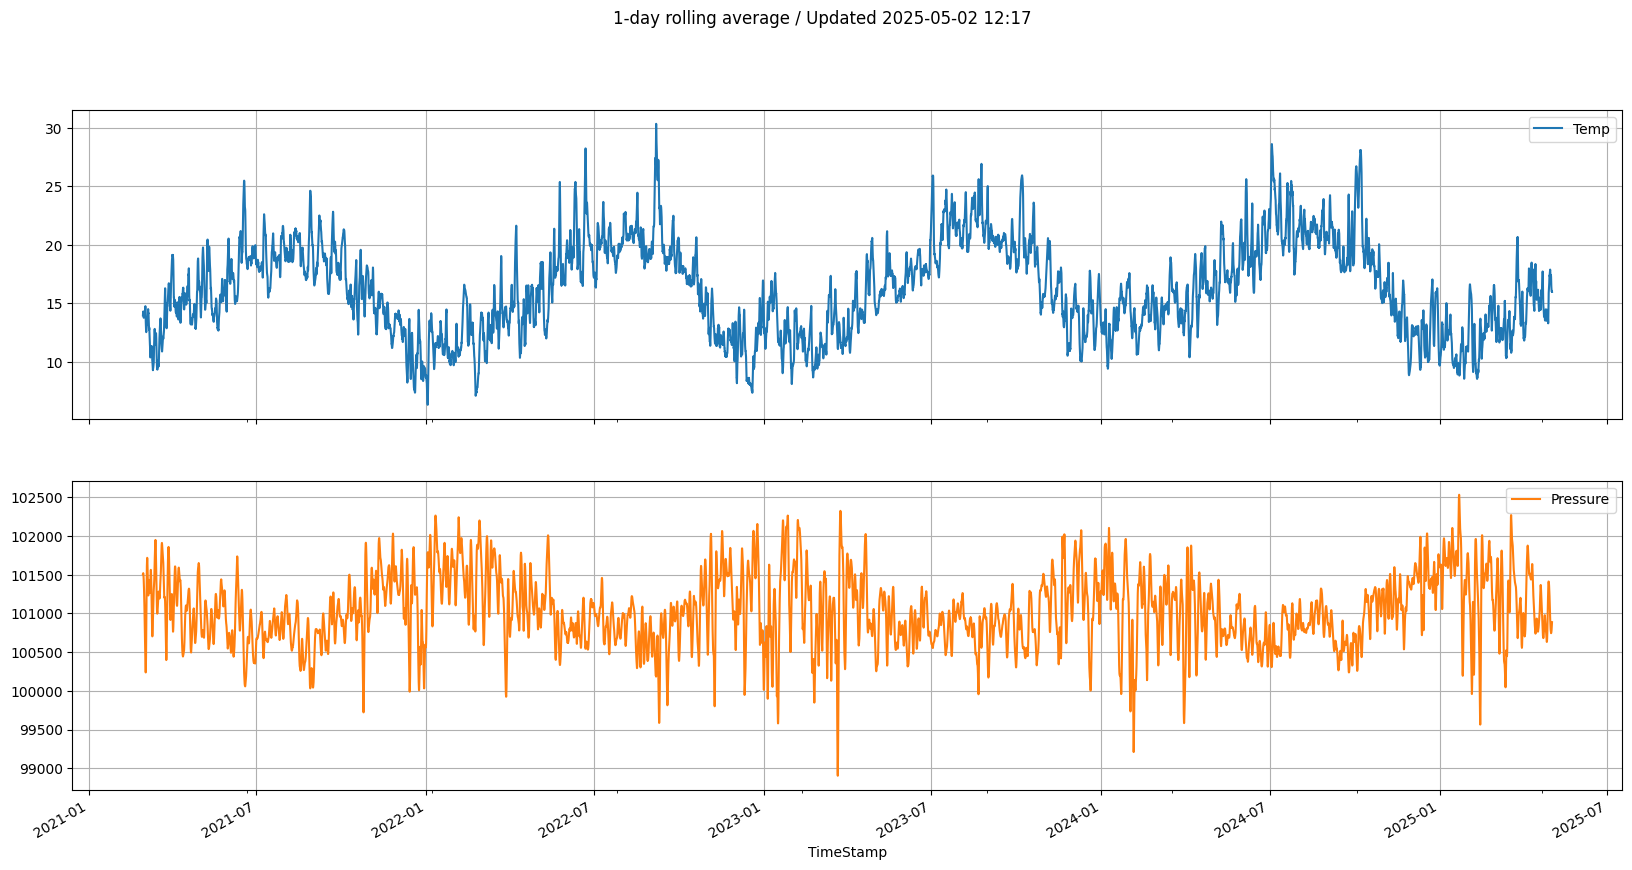

In [14]:
# 1-day rolling average
axs = sensorLog.rolling(24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title=f'1-day rolling average / {UpdatedTimestamp}')
# save plot as file
plt.savefig(graphsPath+'rollingAverage-1day')

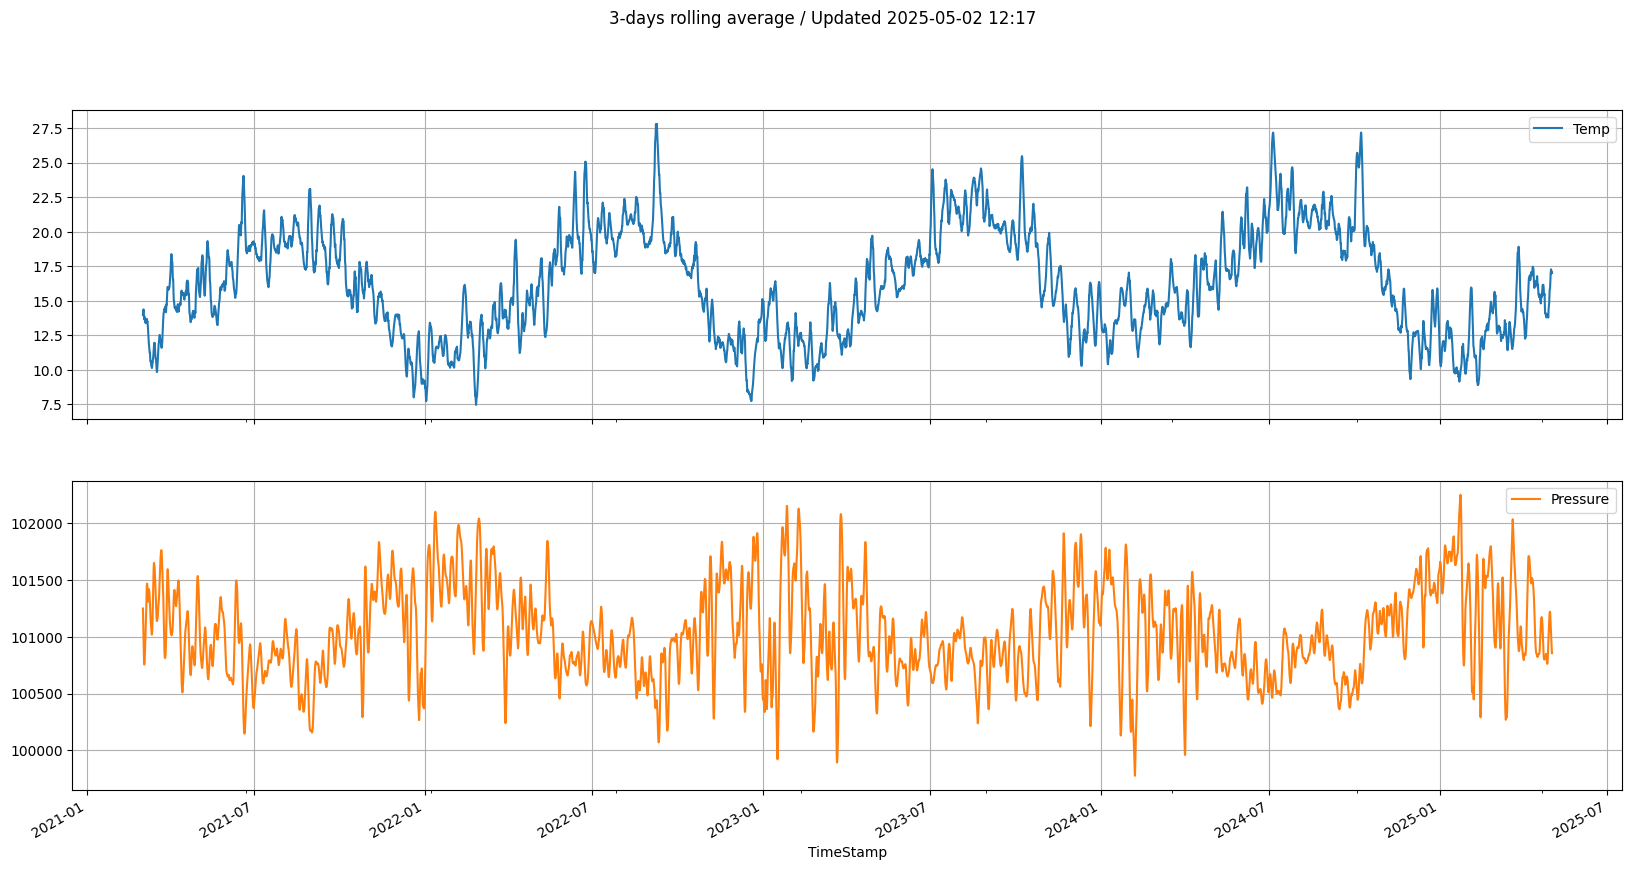

In [15]:
# 3 days rolling average
axs = sensorLog.rolling(3*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title=f'3-days rolling average / {UpdatedTimestamp}')

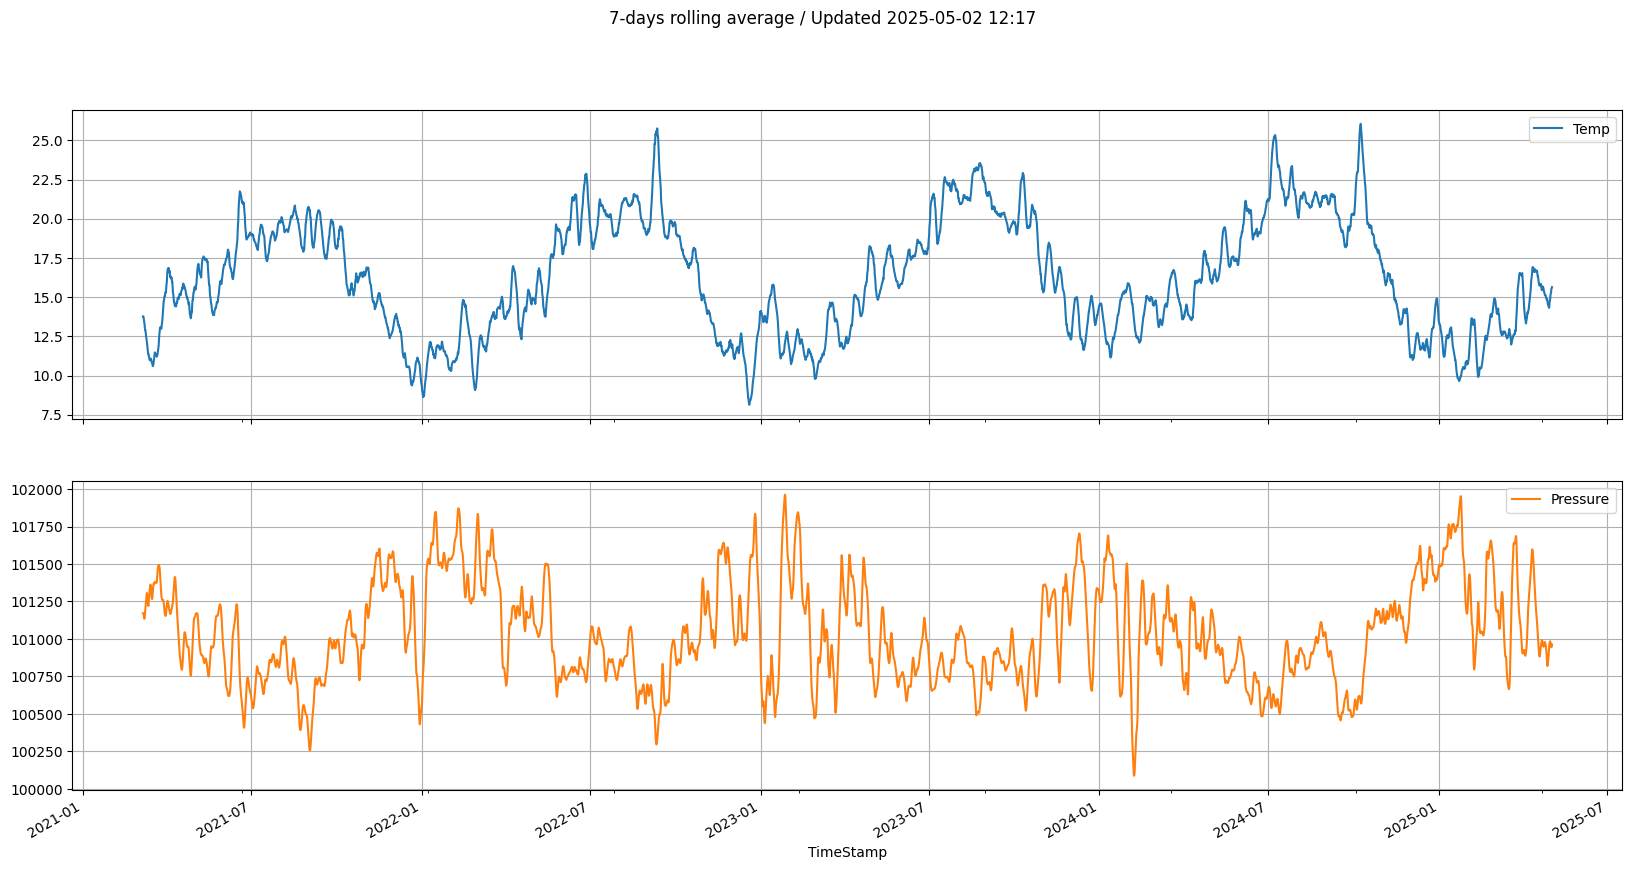

In [16]:
# 7 days rolling average
axs = sensorLog.rolling(7*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title=f'7-days rolling average / {UpdatedTimestamp}')
# save plot as file
plt.savefig(graphsPath+'rollingAverage-7days')

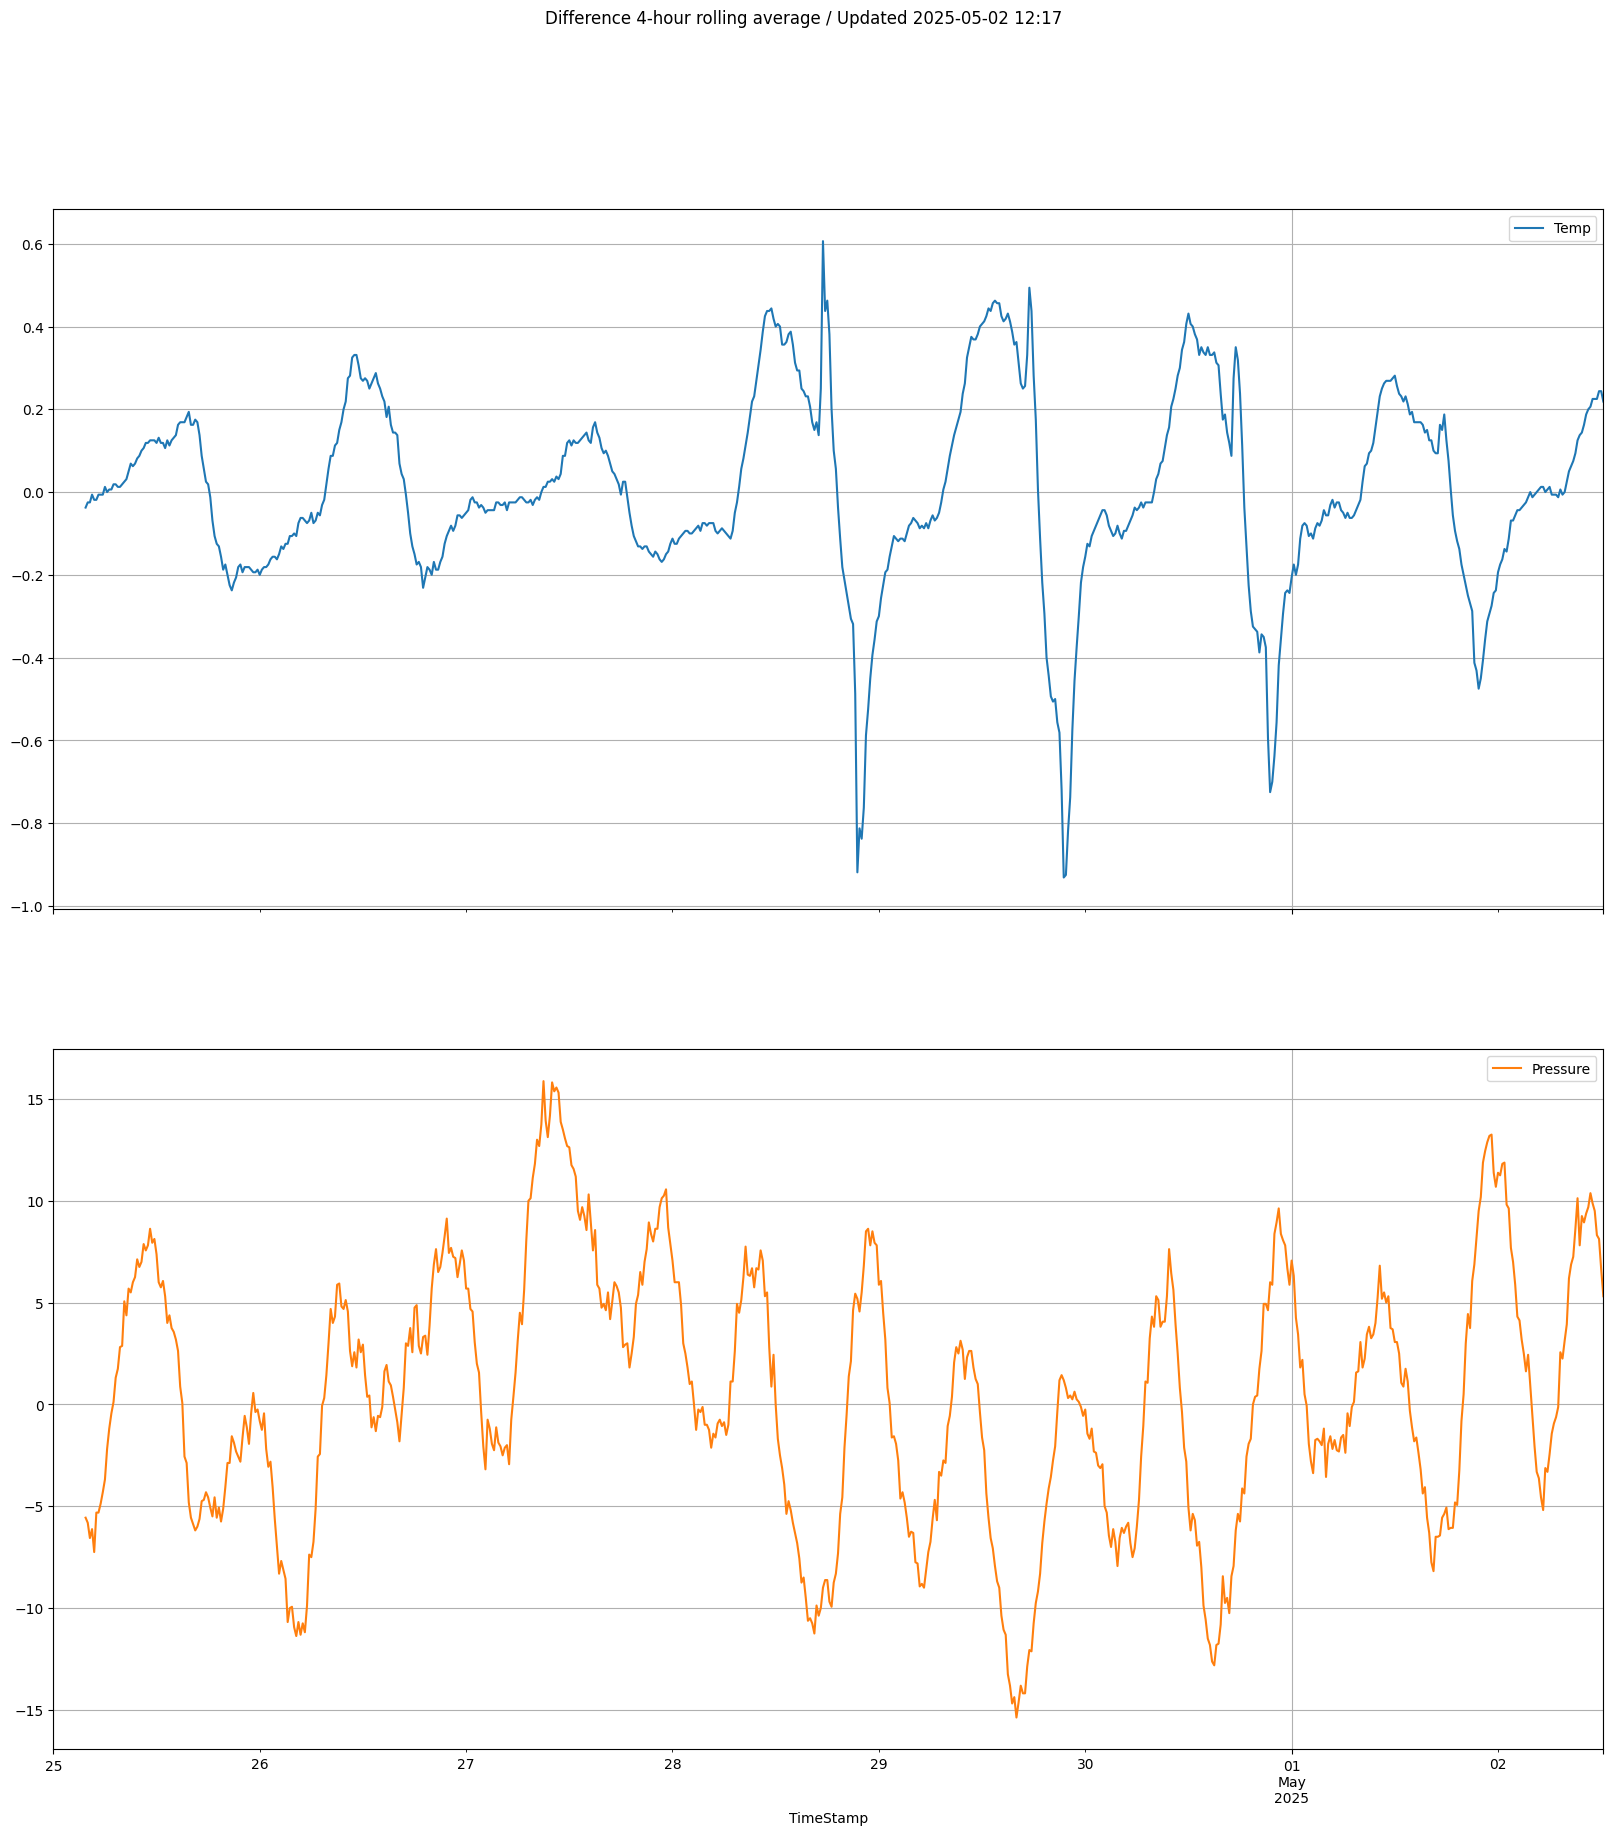

In [17]:
sensorLogDiff = sensorLog.diff()
axs = sensorLogDiff.loc[weekago:today].rolling(4*4).mean().plot(figsize=(20,20), grid=True, subplots=True, title=f'Difference 4-hour rolling average / {UpdatedTimestamp}')
plt.savefig(graphsPath+'Diff-rollingAverage-4hours')

In [18]:
# bar plot daily average, minimum, and maximum temperature
# commented this out because bar charts bocome unplottable with too many data points (2025-04-11)
#axs = sensorLog.resample('D', level=0).mean().plot.bar(title='Daily Average Temperature',
#    y=['Temp'], figsize=(20,10), grid=True)
#axs1 = sensorLog.resample('D', level=0).min().plot.bar(
#    y=['Temp'], figsize=(20,10), grid=True, title='Daily Minimum Temperature')
#axs2 = sensorLog.resample('D', level=0).max().plot.bar(
#    y=['Temp'], figsize=(20,10), grid=True, title='Daily Maximum Temperature')

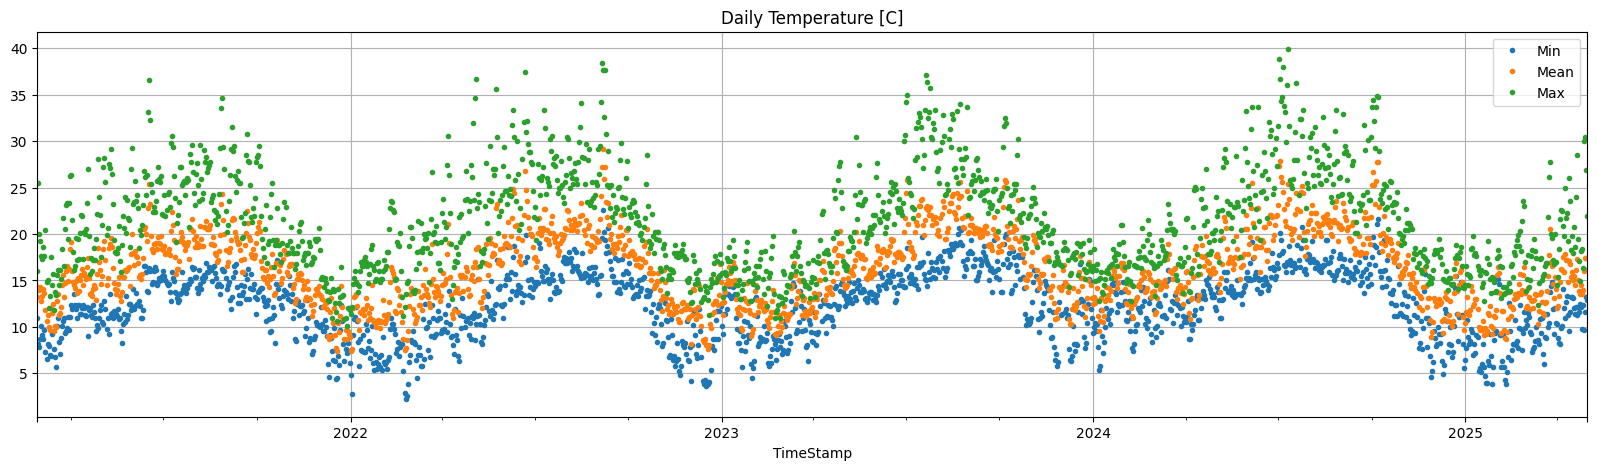

In [19]:
# calculate daily min, mean, max temperature using dataframe resampling
minTemp = sensorLog.loc[:yesterday].resample('D', level=0).min().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Min'})
meanTemp = sensorLog.loc[:yesterday].resample('D', level=0).mean().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Mean'})
maxTemp = sensorLog.loc[:yesterday].resample('D', level=0).max().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Max'})
dailyTemp = minTemp.join(meanTemp, how='outer').join(maxTemp, how='outer')
axs = dailyTemp.plot(figsize=(20,5), grid=True, subplots=False, marker='.', linestyle='None', title='Daily Temperature [C]')

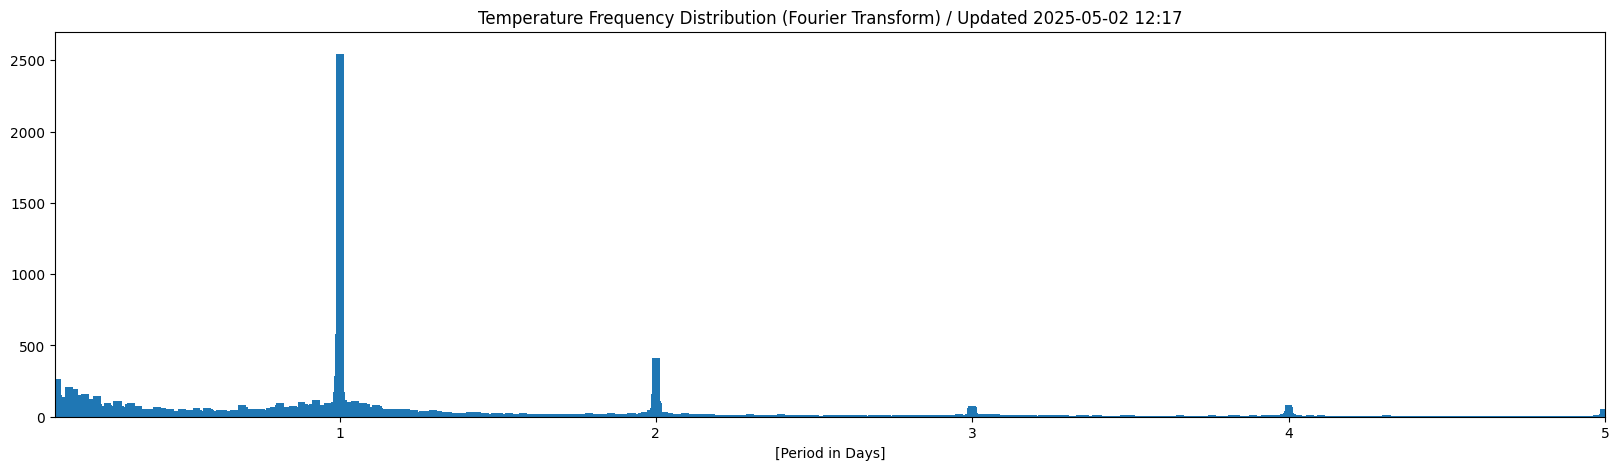

In [20]:
# Calculate and plot Fourier transform of temperature series
# fft (from https://stackoverflow.com/questions/48622933/python-performing-fft-on-csv-values-using-scipy-documentation)
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

temperatureSeries = sensorLog.filter(items=['Temp']).values.flatten() #numpy array format
dt = 15/(24*60) #time increment in unit of days (every 15 minutes)

fft = rfft(temperatureSeries)*dt
freq = rfftfreq(len(temperatureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.1,5])
plt.ylim([0, 2700])
plt.xlabel('[Period in Days]')
plt.title(f'Temperature Frequency Distribution (Fourier Transform) / {UpdatedTimestamp}')
axs = plt.bar(freq, abs(fft), width=0.025)
plt.savefig(graphsPath+'FFT-Temperature')

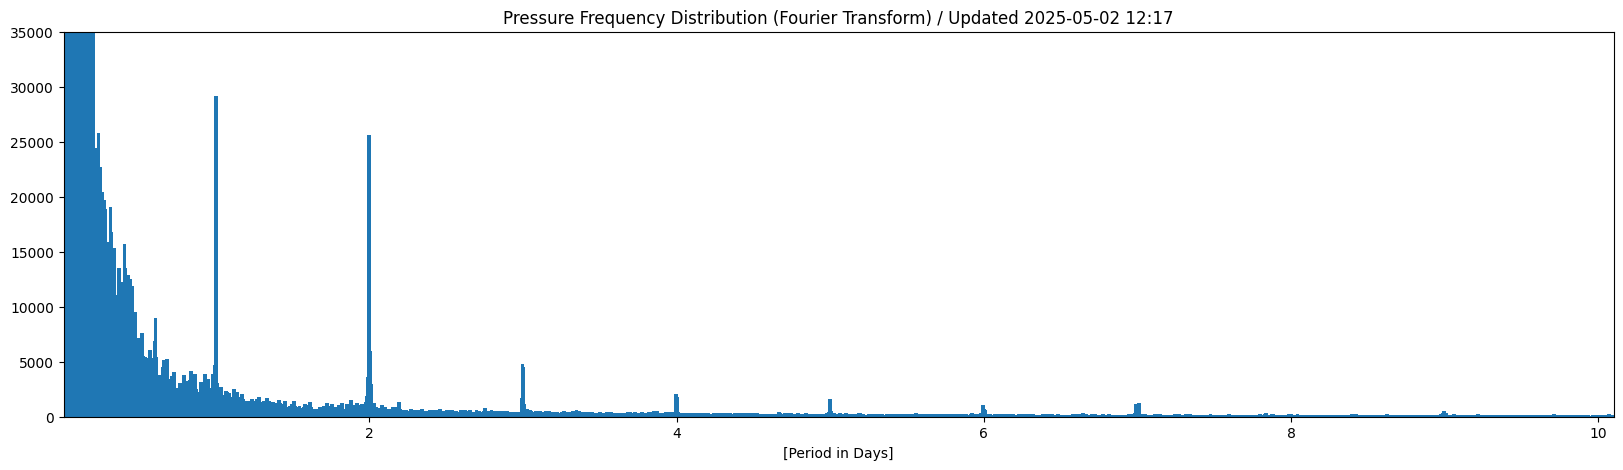

In [21]:
# Calculate and plot Fourier transform of pressure series

pressureSeries = sensorLog.filter(items=['Pressure']).values.flatten() #numpy array format

fft = rfft(pressureSeries)*dt
freq = rfftfreq(len(pressureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.01, 10.1])
plt.ylim([0, 35000])
plt.xlabel('[Period in Days]')
plt.title(f'Pressure Frequency Distribution (Fourier Transform) / {UpdatedTimestamp}')
axs = plt.bar(freq, abs(fft), width=0.025)
plt.savefig(graphsPath+'FFT-Pressure')

In [22]:
freq

array([0.00000000e+00, 6.55939326e-04, 1.31187865e-03, ...,
       4.79983602e+01, 4.79990161e+01, 4.79996720e+01], shape=(73178,))

In [23]:
# ftp plots to website

from AlvaziFTP import AlvaziFTP
ftpSession = AlvaziFTP()

png_files = glob.glob('*.png', root_dir=graphsPath)
for png_file in png_files:
    ftpSession.uploadBinary(graphsPath+png_file)
    print( graphsPath+png_file )

ftpSession.quit()

graphs/pastWeekPlot.png
graphs/rollingAverage-7days.png
graphs/FFT-Pressure.png
graphs/Diff-rollingAverage-4hours.png
graphs/FFT-Temperature.png
graphs/rollingAverage-1day.png


In [24]:
# Get index of minimum and maximum temperature overall
#https://www.geeksforgeeks.org/get-the-index-of-maximum-value-in-dataframe-column/

print(sensorLog[['Temp']].idxmin(), sensorLog[['Temp']].idxmax())

Temp   2022-02-24 06:30:00-08:00
dtype: datetime64[ns, US/Pacific] Temp   2024-07-11 16:30:00-07:00
dtype: datetime64[ns, US/Pacific]


In [25]:
sensorLog.loc[today:today][['Temp']].idxmin()

Temp   2025-05-02 07:00:00-07:00
dtype: datetime64[ns, US/Pacific]

In [26]:
# create dataframe with time of minimum and maximum temperature by date
# adapted from https://stackoverflow.com/questions/29569365/how-to-obtain-the-distribution-of-idmax-idmin-in-timeseries-data
sensorLogByDate = sensorLog.groupby(sensorLog.index.date)
timeMinMaxTemp = pd.DataFrame({'MinTemp_Time': sensorLogByDate['Temp'].idxmin().dt.time, 
                               'MaxTemp_Time': sensorLogByDate['Temp'].idxmax().dt.time})

In [27]:
timeMinMaxTemp.tail(10)

,MinTemp_Time,MaxTemp_Time
2025-04-23,02:45:00,16:15:00
2025-04-24,09:00:00,16:00:00
2025-04-25,23:45:00,16:45:00
2025-04-26,07:00:00,15:00:00
2025-04-27,23:30:00,15:15:00
2025-04-28,06:45:00,17:30:00
2025-04-29,06:45:00,17:30:00
2025-04-30,07:15:00,17:30:00
2025-05-01,06:15:00,17:45:00
2025-05-02,07:00:00,12:15:00


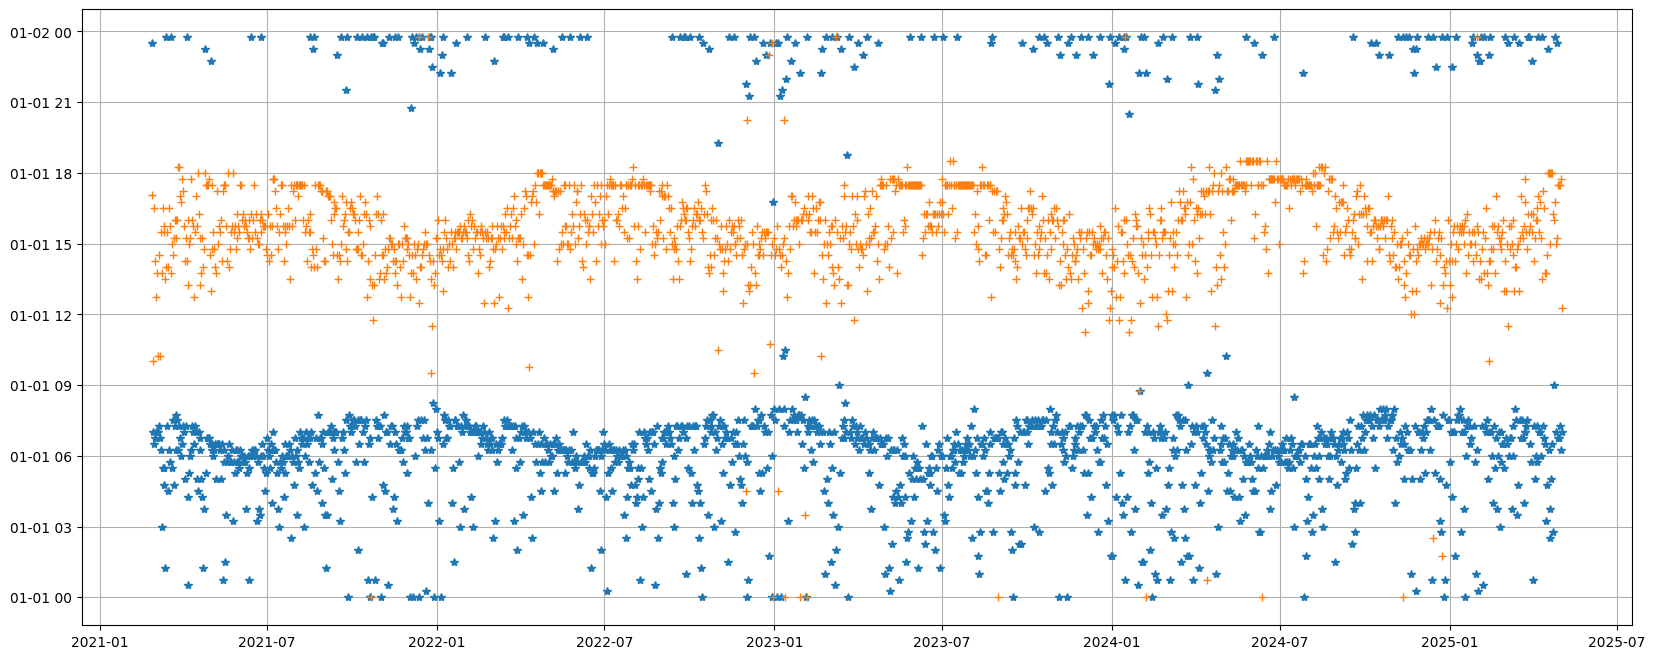

In [28]:
# plot the min/max temperature times by date
minTemp_Time = pd.to_datetime(timeMinMaxTemp.MinTemp_Time, format='%H:%M:%S') #.dt.time
maxTemp_Time = pd.to_datetime(timeMinMaxTemp.MaxTemp_Time, format='%H:%M:%S') #.dt.time
plt.figure(figsize=(20,8))
plt.plot(timeMinMaxTemp.index, minTemp_Time, marker='*', linestyle='None')
plt.plot(timeMinMaxTemp.index, maxTemp_Time, marker='+', linestyle='None')
plt.grid()

https://stackoverflow.com/questions/58263983/how-to-plot-date-in-x-axis-time-in-y-axis-with-pandas-matplotlib-and-present-ti

(add also sunrise sunset times)

In [29]:
minTemp_Time

2021-02-27   1900-01-01 23:30:00
2021-02-28   1900-01-01 07:00:00
2021-03-01   1900-01-01 06:30:00
2021-03-02   1900-01-01 06:45:00
2021-03-03   1900-01-01 07:00:00
                     ...        
2025-04-28   1900-01-01 06:45:00
2025-04-29   1900-01-01 06:45:00
2025-04-30   1900-01-01 07:15:00
2025-05-01   1900-01-01 06:15:00
2025-05-02   1900-01-01 07:00:00
Name: MinTemp_Time, Length: 1526, dtype: datetime64[ns]

In [30]:
sensorLog.tail(50)

,Temp,Pressure
TimeStamp,,
2025-05-02 00:00:00-07:00,13.6,100925.0
2025-05-02 00:15:00-07:00,13.6,100938.0
2025-05-02 00:30:00-07:00,13.4,100958.0
2025-05-02 00:45:00-07:00,13.5,100967.0
2025-05-02 01:00:00-07:00,13.2,100961.0
2025-05-02 01:15:00-07:00,13.2,100972.0
2025-05-02 01:30:00-07:00,13.4,100969.0
2025-05-02 01:45:00-07:00,13.2,100972.0
2025-05-02 02:00:00-07:00,13.2,100966.0


In [31]:
# Calculate difference between successive timestamps and print those with absolute value > 15 minutes
# This should show power outages or other downtimes
diffs = sensorLog.index.to_series().diff() #.dropna()
diffs_in_seconds = diffs.dt.total_seconds()
gap_Minutes = 15
filtered_diffs = [(str(idx), diff) for idx, diff in zip(diffs.index[1:], diffs_in_seconds) if abs(diff) > gap_Minutes*60]
print(f"Gaps in time series greater than {gap_Minutes} minutes:")
for timestamp, diff in filtered_diffs:
    print(f"Timestamp: {timestamp}, Difference: {diff/60} minutes")

Gaps in time series greater than 15 minutes:
Timestamp: 2021-07-07 07:15:00-07:00, Difference: 75.0 minutes
Timestamp: 2021-10-24 19:00:00-07:00, Difference: 60.0 minutes
Timestamp: 2022-09-05 20:30:00-07:00, Difference: 135.0 minutes
Timestamp: 2022-09-05 23:00:00-07:00, Difference: 120.0 minutes
Timestamp: 2025-03-12 07:45:00-07:00, Difference: 30.0 minutes


In [32]:
print(diffs_in_seconds.index[1])
print(diffs_in_seconds.iloc[1])
diffs.head(10)
diffs_in_seconds.head(10)

2021-02-27 17:15:00-08:00
720.0


TimeStamp
2021-02-27 17:03:00-08:00      NaN
2021-02-27 17:15:00-08:00    720.0
2021-02-27 17:30:00-08:00    900.0
2021-02-27 17:45:00-08:00    900.0
2021-02-27 18:00:00-08:00    900.0
2021-02-27 18:15:00-08:00    900.0
2021-02-27 18:30:00-08:00    900.0
2021-02-27 18:45:00-08:00    900.0
2021-02-27 19:00:00-08:00    900.0
2021-02-27 19:15:00-08:00    900.0
Name: TimeStamp, dtype: float64

In [33]:
filtered_diffs

[('2021-07-07 07:15:00-07:00', 4500.0),
 ('2021-10-24 19:00:00-07:00', 3600.0),
 ('2022-09-05 20:30:00-07:00', 8100.0),
 ('2022-09-05 23:00:00-07:00', 7200.0),
 ('2025-03-12 07:45:00-07:00', 1800.0)]